<a href="https://colab.research.google.com/github/j-kohmaru-gunma/AraMaNet/blob/main/AraMaNet_Library.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **AraMaNet Class**

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from matplotlib.animation import FuncAnimation

class AramaNet:

    def __init__(self, input_dim=2,max_depth=2,max_vnode=32):
        self.input_dim = input_dim
        self.vertex = VertexUnit(input_dim,max_nodes=max_vnode)
        self.simplex = []

    def forward(self, x, recon_error=0.1, max_depth=32):

        result = {}
        out_layer = -1

        result["out"] = self.vertex.forward(x)

        for i in range(min(max_depth,len(self.simplex))):
            result["out"] = self.simplex[i].forward(result["out"])
            out_layer += 1

        result["sparse_rate"] = self.get_sparse_rate(result["out"])
        result["idx"] = [np.argmax(result["out"])]
        result["vertex"] = self.get_vertex(out_layer,result["idx"])
        recon ,error = self.reconstruct_and_error(x, result["vertex"])
        result["recon"] = recon
        result["error"] = np.min(error)

        return result

    def train(self, X, input_dim=2, max_depth=2):

        self.vertex.train(X)

        layer_count = 0
        rec_rate = 0
        error = np.ones(len(X))
        rec_threshold = 0.05

        print("Number of Data:",len(X))
        print("rec_threshold :",rec_threshold)
        while True:
            out = []
            for i in range(len(X)):

                if error[i] < rec_threshold: continue

                result = net.forward(X[i])

                out.append(result["out"])

                error[i] = result["error"]

            num = np.count_nonzero(error < rec_threshold)
            rec_rate = round(num/len(error),6)

            print(
                "layer:",layer_count,
                " recon_rate:",rec_rate*100,"%(",num,"/",len(error),")",
            )

            layer_count += 1
            if layer_count >= self.input_dim+1 or rec_rate > 98:
                break;

            self.simplex.append(SimplexUnit(k=layer_count+1))
            self.simplex[layer_count-1].optimize(out)

    def get_vertex(self,layer_num=0,node_idx=[0]):

        for i in range(layer_num+1):
            if len(self.simplex[layer_num-i].connect) > 0:
                node_idx = self.simplex[layer_num-i].connect[node_idx]
            else:
                node_idx = np.argsort(-self.simplex[layer_num-i].weights[node_idx])[:self.simplex[i].k]

        return np.unique(node_idx)

    def get_sparse_rate(self,y):

        sorted_y = np.sort(y)[::-1]
        sr = 1

        sr = (sorted_y[0] - sorted_y[1]) / (sorted_y[0] + 1e-8)

        #sr = sorted_y[0] - sorted_y[1]

        #sr = sorted_y[0] / np.sum(sorted_y) * len(sorted_y)

        return sr

    def reconstruct_and_error(self, x, idx_list):
        points = self.vertex.centers[idx_list]
        inv_d = self.vertex.out[idx_list]
        weights = (inv_d / np.sum(inv_d))
        recon = np.sum(points * weights[:, np.newaxis], axis=0)
        return recon, np.linalg.norm(x - recon, axis=0)


class VertexUnit:

    def __init__(self, input_dim=2, max_nodes=32, sparse_rate=0.2):
        self.input_dim = input_dim
        self.centers = np.zeros((max_nodes, input_dim))
        self.max_nodes = max_nodes
        self.sparse_rate = sparse_rate
        self.out = np.zeros(len(self.centers))
        self.scores = np.zeros(len(self.centers))
        self.centers_log = []
        self.scores_log = []

    def forward(self, x):
        dists = np.linalg.norm(x - self.centers, axis=1)
        self.out = 1 / (dists + 1e-8)

        self.out = self.sparse(self.out)

        return self.out

    def train(self, X, epochs=200):

        idx = np.random.choice(len(X), size=self.max_nodes, replace=False)
        self.centers = X[idx]

        self.centers_log.append(self.centers.copy())
        self.scores_log.append(self.scores.copy())

        for i in range(epochs):

            for x in X:
              self.update(x)

            self.centers_log.append(self.centers.copy())
            self.scores_log.append(self.scores.copy())

            if i % 3 == 0:
              self.redistribute_nodes()

    def update(self, x):

        y = self.forward(x)

        sort_idx = np.argsort(y)[::-1]
        winner_idx = sort_idx[0]
        winner_y = y[winner_idx]

        normalized_y = y / np.sum(y)

        winner_uniqueness = (y[sort_idx[0]] - y[sort_idx[1]]) / (y[sort_idx[0]] + 1e-6)

        move_amount = winner_uniqueness

        self.centers[winner_idx] += 0.1 * (x - self.centers[winner_idx])

        self.scores[winner_idx] += 1

    def redistribute_nodes(self, perturb_std=0.05):

        if self.max_nodes < 2:
            return

        sorted_indices = np.argsort(self.scores)
        prune_idx = sorted_indices[0]
        top_indices = sorted_indices[-max(1, self.max_nodes//3):]
        dup_idx = np.random.choice(top_indices)

        perturb = np.random.randn(self.input_dim) * perturb_std
        self.centers[prune_idx] = self.centers[dup_idx] + perturb

        self.scores[[prune_idx,dup_idx]] = self.scores[dup_idx] * 0.5

    def sparse(self, x):
      return x

class SimplexUnit:
    def __init__(self, input_dim=2, max_nodes=32, k=2, sparse_rate=0.6):
        self.max_nodes = max_nodes
        self.k = k
        self.connect = np.zeros((0,k),dtype=np.int32)
        self.connect_weight = np.zeros(0)
        self.out = np.array([])
        self.out_idx = np.array([])
        self.weights = np.abs(np.random.rand(max_nodes, input_dim))


    def forward(self, x):

        if len(self.connect) > 0:
            topk_indices = self.connect

        else:
            topk_indices = np.argpartition(-self.weights, kth=self.k-1, axis=0)[:, :self.k]

        topk_values = np.take_along_axis(x[None, :], topk_indices, axis=1)

        valid_counts = np.full((len(topk_indices)), self.k)
        sums = np.sum(topk_values, axis=1)
        self.out = sums / valid_counts

        return self.out

    def optimize(self, X, max_nodes=31):
        top_k = np.argsort(X)[:,-self.k:]
        top_k = np.sort(top_k,axis=1)

        unique_rows, counts = np.unique(top_k, axis=0, return_counts=True)
        idx = np.argsort(-counts)
        unique_rows = unique_rows[idx][0:max_nodes]
        counts = counts[idx][0:max_nodes]
        for row, count in zip(unique_rows, counts):
            self.connect = np.insert(self.connect, 0, row, axis=0)
            self.connect_weight = np.insert(self.connect_weight, 0, count, axis=0)

        return unique_rows, counts



### **Training**

In [6]:
# Swiss Roll Data
X, _ = make_swiss_roll(n_samples=1000, noise=0.2)
X = X[:, [0, 2]]
X = (X / np.max(np.abs(X)))

# Initiation
net = AramaNet(input_dim=len(X[0]),max_vnode=32)

# Train
net.train(X)

Number of Data: 1000
rec_threshold : 0.05
layer: 0  recon_rate: 54.6 %( 546 / 1000 )
layer: 1  recon_rate: 98.7 %( 987 / 1000 )
layer: 2  recon_rate: 99.0 %( 990 / 1000 )


### **Vertex Node Training Animation**

In [ ]:
#!apt-get -y install ffmpeg

centers = net.vertex.centers_log
scores = net.vertex.scores_log

fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_xlim(np.min(X[:, 0]), np.max(X[:, 0]))
ax.set_ylim(np.min(X[:, 1]), np.max(X[:, 1]))
scat_data = ax.scatter(X[:, 0], X[:, 1], s=2, c='gray', alpha=0.2, label='data')
scat_nodes = ax.scatter([], [], s=20, c=[], cmap='rainbow', label='nodes')
def init():
    scat_nodes.set_offsets(np.empty((0, 2)))
    return scat_nodes,
def update(frame):
    scat_nodes.set_offsets(centers[frame])
    score = scores[frame]/np.mean(scores[frame])
    scat_nodes.set_array(score)
    return scat_nodes,
anim = FuncAnimation(fig, update, frames=len(centers)-1, init_func=init, interval=50, blit=True)

# Save MP4
anim.save("training_animation.mp4", writer="ffmpeg", fps=5)

# Download
from google.colab import files
files.download("training_animation.mp4")
plt.close()


/tmp/ipython-input-107-2501486870.py:18: RuntimeWarning: invalid value encountered in divide
  score = scores[frame]/np.mean(scores[frame])  # shape=(ノード数,)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Vertex Node Visualize**

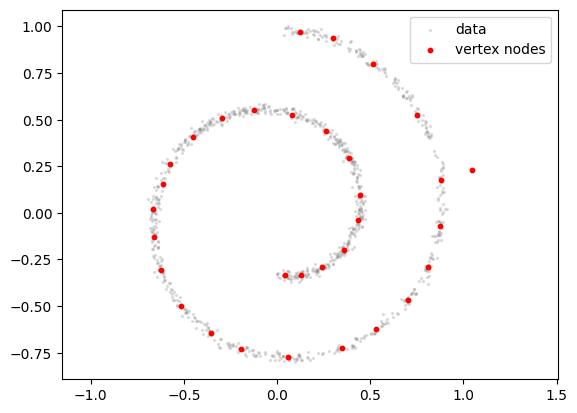

In [7]:

fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_xlim(np.min(X[:, 0]), np.max(X[:, 0]))
ax.set_ylim(np.min(X[:, 1]), np.max(X[:, 1]))

plt.scatter(X[:, 0], X[:, 1], s=2, label='data', c='gray', alpha=0.2)
plt.scatter(net.vertex.centers[:, 0], net.vertex.centers[:, 1], c='red', label='vertex nodes', s=10)

plt.legend()
plt.axis("equal")
plt.show()

### **1st Simplex Node Visualize**

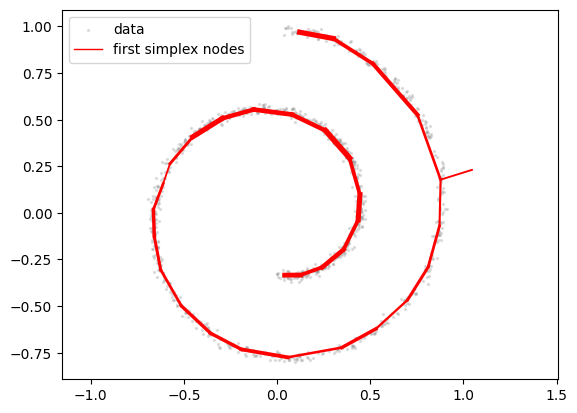

In [8]:

fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_xlim(np.min(X[:, 0]), np.max(X[:, 0]))
ax.set_ylim(np.min(X[:, 1]), np.max(X[:, 1]))

line_idx = net.simplex[0].connect
w = net.simplex[0].connect_weight
w = w/np.max(w)
for i in range(len(line_idx)):
    p1 = net.vertex.centers[line_idx[i,0]]
    p2 = net.vertex.centers[line_idx[i,1]]
    plt.plot([p1[0],p2[0]], [p1[1],p2[1]], c='red', lw=w[i]*4)

plt.scatter(X[:, 0], X[:, 1], s=2, label='data', c='gray', alpha=0.2)
plt.plot([p1[0],p2[0]], [p1[1],p2[1]], c='red', label='first simplex nodes', lw=1)

plt.legend()
plt.axis("equal")
plt.show()

### **Vertex Layer Reconstruction Accuracy**

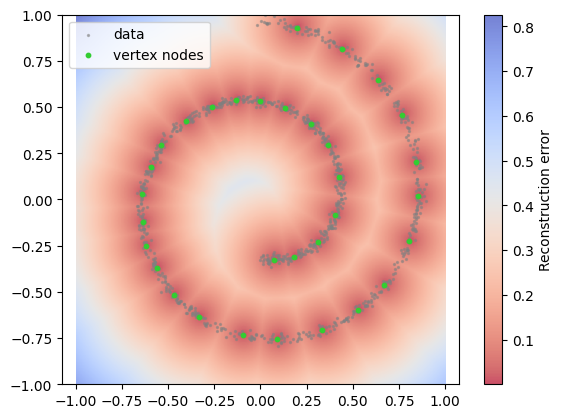

In [ ]:

Z = np.zeros((255,255))
for i in range(255):
    for j in range(255):
        y = i / 255 * 2 - 1  # [0,255] → [-1,1]
        x = j / 255 * 2 - 1
        Z[i,j] = (net.forward([x,y],max_depth=0))["error"]

fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_xlim(np.min(X[:, 0]), np.max(X[:, 0]))
ax.set_ylim(np.min(X[:, 1]), np.max(X[:, 1]))

heatmap = ax.imshow(Z, cmap='coolwarm_r',origin="lower", extent=[-1, 1, -1, 1], alpha=0.7)
plt.colorbar(heatmap, ax=ax, label='Reconstruction error')

plt.scatter(X[:, 0], X[:, 1], s=2, label='data', c='gray', alpha=0.5)
plt.scatter(net.vertex.centers[:, 0], net.vertex.centers[:, 1], c='limegreen', label='vertex nodes', s=10)

plt.legend()
plt.axis("equal")
plt.show()

### **1st Simplex Layer Reconstruction Accuracy**

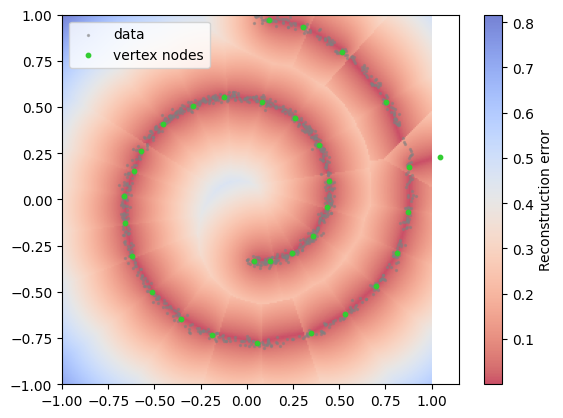

In [9]:

Z = np.zeros((255,255))
for i in range(255):
    for j in range(255):
        y = i / 255 * 2 - 1  # [0,255] → [-1,1]
        x = j / 255 * 2 - 1
        Z[i,j] = (net.forward([x,y],max_depth=1))["error"]


fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_xlim(np.min(X[:, 0]), np.max(X[:, 0]))
ax.set_ylim(np.min(X[:, 1]), np.max(X[:, 1]))

heatmap = ax.imshow(Z, cmap='coolwarm_r',origin="lower", extent=[-1, 1, -1, 1], alpha=0.7)
plt.colorbar(heatmap, ax=ax, label='Reconstruction error')

plt.scatter(X[:, 0], X[:, 1], s=2, label='data', c='gray', alpha=0.5)
plt.scatter(net.vertex.centers[:, 0], net.vertex.centers[:, 1], c='limegreen', label='vertex nodes', s=10)

plt.legend()
plt.axis("equal")
plt.show()

### **Total Reconstruction Accuracy**

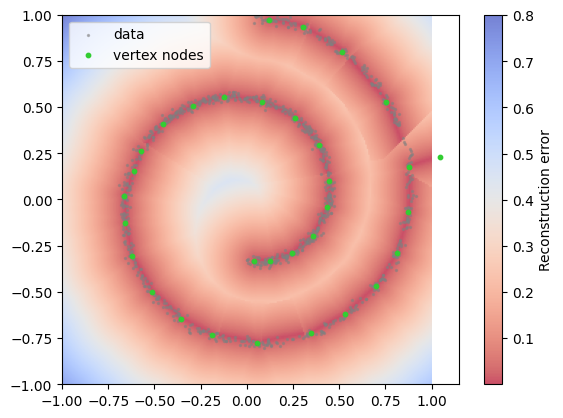

In [10]:

Z = np.zeros((255,255))
for i in range(255):
    for j in range(255):
        y = i / 255 * 2 - 1  # [0,255] → [-1,1]
        x = j / 255 * 2 - 1
        Z[i,j] = min((net.forward([x,y],max_depth=0))["error"],(net.forward([x,y],max_depth=1))["error"])

fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_xlim(np.min(X[:, 0]), np.max(X[:, 0]))
ax.set_ylim(np.min(X[:, 1]), np.max(X[:, 1]))

heatmap = ax.imshow(Z, cmap='coolwarm_r',origin="lower", extent=[-1, 1, -1, 1], alpha=0.7)
plt.colorbar(heatmap, ax=ax, label='Reconstruction error')

plt.scatter(X[:, 0], X[:, 1], s=2, label='data', c='gray', alpha=0.5)
plt.scatter(net.vertex.centers[:, 0], net.vertex.centers[:, 1], c='limegreen', label='vertex nodes', s=10)

plt.legend()
plt.axis("equal")
plt.show()